In [1]:
import random as python_random

from matplotlib import pyplot as plt
plt.style.use('ggplot')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15/1.6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


import numpy as np
import pandas as pd

import yfinance as yf

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [9]:
t={'Models':'','Weights':[],'R_squared':0}

In [10]:
t['Models']=['1 model','2 model','3 model']
t['Weights']=[[0.11,0.21,0.11],[0.12,0.22,0.12],[0.13,0.23,0.13]]
t['R_squared']=[0.25,0.60,0.92]


In [11]:
t

{'Models': ['1 model', '2 model', '3 model'],
 'Weights': [[0.11, 0.21, 0.11], [0.12, 0.22, 0.12], [0.13, 0.23, 0.13]],
 'R_squared': [0.25, 0.6, 0.92]}

In [2]:
def MAPE(y_hat,y_pred):
    mape = np.mean(np.abs((y_hat - y_pred)/y_hat))*100
    return mape

def RMSE(y_hat,y_pred):
    MSE = np.square(np.subtract(y_hat,y_pred)).mean() 
    return (MSE**(1/2))


In [3]:
phys_dev=tf.config.list_physical_devices("GPU")
if len(phys_dev)!=0:
    tf.config.experimental.set_memory_growth(phys_dev[0],True)    
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')),"\n","Tensorflow version: ", tf.__version__)

Num GPUs Available:  1 
 Tensorflow version:  2.4.1


In [90]:
#PARAMETERS
EPOCHS=1000
BATCH_SIZE=256
RANDOMSEED=123

SELECTED_STOCK='MSFT'

np.random.seed(RANDOMSEED)
python_random.seed(RANDOMSEED)
tf.random.set_seed(RANDOMSEED)

stock=yf.Ticker(SELECTED_STOCK).history(start='2015-01-01',end='2021-01-01')

In [91]:
class Dataset():
    def __init__(self, data, target='Close',timeseries=True,scale=True,look_forw=1,look_back=60,test_size=0.2):
    #Store the raw data.    
        self.split=int(len(data)*(1-test_size))
        self.Scaler=None
        self.target_col=data.columns.get_loc(target)
        self.look_forw = look_forw
        self.look_back=look_back
        self.train_dates=data.iloc[:self.split,:].index
        self.test_dates=data.iloc[self.split-self.look_back:,:].index

        #self.Data=data.dropna(subset=['Close'],how='any')   
        
        self.Train = np.array(data.iloc[:self.split,:])
        self.Test = np.array(data.iloc[self.split-self.look_back:,:])

        if timeseries==True:
            self.Train=self.Train[:,self.target_col].reshape(-1,1)
            self.Test=self.Test[:,self.target_col].reshape(-1,1)  
        
        if scale==True:
            self.Scaler=MinMaxScaler(feature_range = (-1, 1))
            self.Scaler=self.Scaler.fit(self.Train)
        
            self.Train=self.Scaler.transform(self.Train)
            self.Test=self.Scaler.transform(self.Test)
        
        self.X_train_seq=[]
        self.y_train_seq=[]
        for i in range(self.look_back,len(self.Train)-self.look_forw+1):
            self.X_train_seq.append(self.Train[i-self.look_back:i,:])
                
            if timeseries==True:
                self.y_train_seq.append(self.Train[i+self.look_forw-1])
            else:
                self.y_train_seq.append(self.Train[i+self.look_forw-1,self.target_col])

        self.X_train_seq=np.array(self.X_train_seq).astype('float32')
        self.y_train_seq=np.array(self.y_train_seq,dtype='object').astype('float32')

        self.X_train_seq=self.X_train_seq.reshape(self.X_train_seq.shape[0],self.X_train_seq.shape[1],self.X_train_seq.shape[2])

        self.X_test_seq=[]
        for i in range(self.look_back,len(self.Test)):
                self.X_test_seq.append(self.Test[i-self.look_back:i,:])
                
        self.X_test_seq=np.asarray(self.X_test_seq).astype('float32')
        self.X_test_seq=self.X_test_seq.reshape(self.X_test_seq.shape[0],self.X_test_seq.shape[1],self.X_test_seq.shape[2])

        print(self.__repr__())

    def __repr__(self):
        return '\n'.join([
        f'Original train and test{self.Train.shape,self.Test.shape}',
        f'X train size {self.X_train_seq.shape}',
        f'Y train size: {self.y_train_seq.shape}',
        f'X test size: {self.X_test_seq.shape}'])

In [92]:
data=Dataset(stock,look_back=60,look_forw=1,timeseries=True,scale=True)
true_stock=stock.Close[data.split:].values
input_shape=(data.look_back,data.X_train_seq.shape[2])

Original train and test((1209, 1), (363, 1))
X train size (1149, 60, 1)
Y train size: (1149, 1)
X test size: (303, 60, 1)


In [93]:
_mape=tf.keras.metrics.MeanAbsolutePercentageError()
_rmse=tf.keras.metrics.RootMeanSquaredError()

In [94]:
#CALLBACKS
es=EarlyStopping(monitor='val_loss',min_delta=1e-3,mode="min",patience=10,verbose=1)
rlr=ReduceLROnPlateau(monitor='val_loss',min_delta=1e-2,factor=0.75,cooldown=5,mode='min',patience=3,verbose=1)

kernel_reg=keras.regularizers.l1_l2(l1=0.01, l2=0.01)
bias_reg=keras.regularizers.l1_l2(l1=0.01, l2=0.01)
recurrent_reg=keras.regularizers.l1_l2(l1=0.001, l2=0.001)
act_reg=keras.regularizers.l1_l2(l1=0.001, l2=0.001)

optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)

In [95]:
LSTM_Models={'Name':[],'Model':[],'History':[],'Preds':[]}

In [96]:
default_lstm = Sequential([
    layers.LSTM(units=50, return_sequences=True,input_shape=input_shape),
    layers.LSTM(units=50, return_sequences=False),
    layers.Dense(units=data.y_train_seq.shape[1])
]) 
  
default_lstm.compile(optimizer=optimizer,loss=['mse'],metrics=[_mape])
LSTM_Models['Name'].append('Default LSTM')
LSTM_Models['Model'].append(default_lstm)

In [97]:
base_lstm = Sequential([
    layers.LSTM(units=50, return_sequences=True,input_shape=input_shape,activation='linear'),
    layers.Dropout(0.1),
    layers.LSTM(units=50, return_sequences=False),
    layers.Dropout(0.1),
    layers.Dense(units=data.y_train_seq.shape[1])
]) 
  
base_lstm.compile(optimizer=optimizer,loss=['mse'],metrics=[_mape])
LSTM_Models['Name'].append('Base LSTM')
LSTM_Models['Model'].append(base_lstm)

In [98]:
gelu_lstm = Sequential([
    layers.LSTM(units=50, return_sequences=True,input_shape=input_shape,activation='gelu'),
    layers.Dropout(0.8),
    layers.LSTM(units=50, return_sequences=False),
    layers.Dropout(0.8),
    layers.Dense(units=data.y_train_seq.shape[1])
]) 
  
gelu_lstm.compile(optimizer=optimizer,loss=['mse'],metrics=[_mape])
LSTM_Models['Name'].append('GELU LSTM')
LSTM_Models['Model'].append(gelu_lstm)

In [99]:
swish_lstm = Sequential([
    layers.LSTM(units=50, return_sequences=True,input_shape=input_shape,activation='swish'),
    layers.Dropout(0.1),
    layers.LSTM(units=50, return_sequences=False),
    layers.Dropout(0.1),
    layers.Dense(units=data.y_train_seq.shape[1],activation='relu')
]) 
  
swish_lstm.compile(optimizer=optimizer,loss=['mse'],metrics=[_mape])
LSTM_Models['Name'].append('Swish LSTM')
LSTM_Models['Model'].append(swish_lstm)

In [100]:
for model in LSTM_Models['Model']:
    history=model.fit(data.X_train_seq,data.y_train_seq, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, verbose=0, callbacks=[es,rlr])
    preds_scaled=model.predict(data.X_test_seq)
    preds=data.Scaler.inverse_transform(np.repeat(preds_scaled,data.Train.shape[1],axis=1))[:,0]
    LSTM_Models['Preds'].append(preds)
    LSTM_Models['History'].append(history)


Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
Epoch 00018: early stopping

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0004218749818392098.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00031640623637940735.
Epoch 00015: early stopping

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00023730468819849193.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00017797851614886895.
Epoch 00022: early stopping

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0001334838816546835.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010011290578404441.
Epoch 00016: early stopping


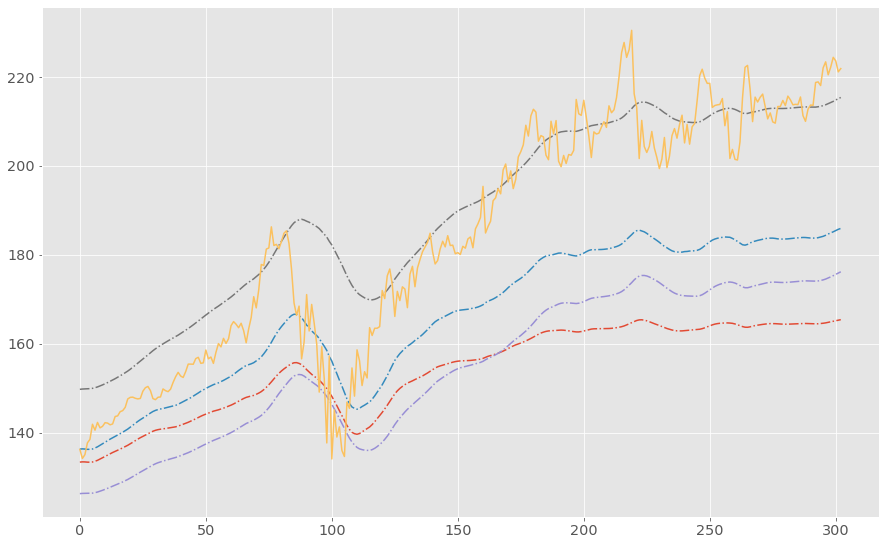

In [101]:
for element in LSTM_Models['Preds']:
    plt.plot(element,'-.')
plt.plot(true_stock)

In [102]:
lstm_prediction=np.array(LSTM_Models['Preds'])

In [103]:
def ensemble_loss(weights):
    weighted_preds=np.dot(weights,lstm_prediction)
    return RMSE(true_stock.reshape(-1,1),weighted_preds)


In [104]:
import scipy.optimize as optimize

In [105]:
opt_weights = optimize.minimize(ensemble_loss,
                                [1/len(LSTM_Models.keys())] * len(LSTM_Models.keys()),
                                constraints=({'type': 'eq','fun': lambda w: 1-sum(w)}),
                                method= 'SLSQP', 
                                bounds=[(0.0, 1.0)] * len(LSTM_Models.keys()),
                                options = {'ftol':1e-10},
                            )['x']
preds=np.dot(opt_weights,lstm_prediction)

[]

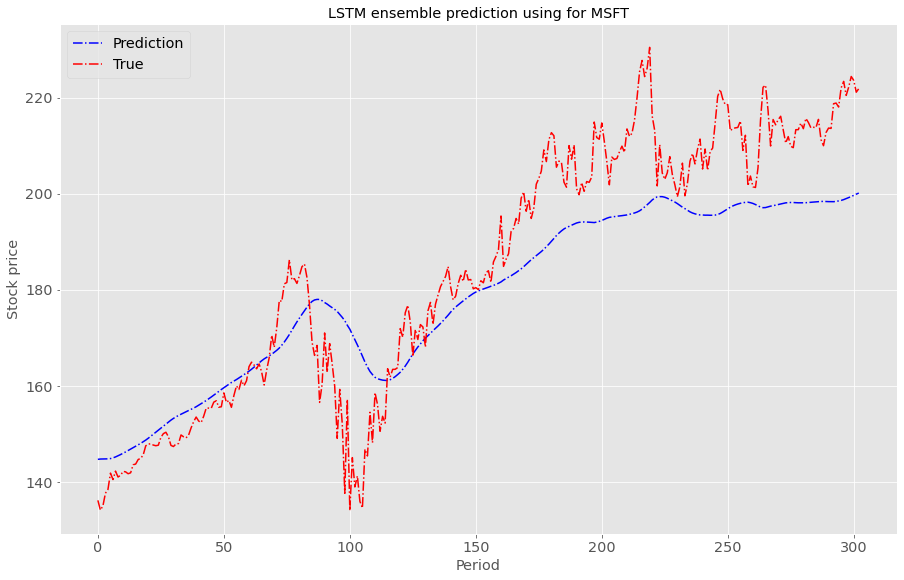

In [106]:
plt.plot(preds,'b-.',label='Prediction')
plt.plot(true_stock,'r-.',label='True')
plt.xlabel('Period')
plt.title(f'LSTM ensemble prediction using for {SELECTED_STOCK}')
plt.ylabel('Stock price')
plt.legend()
plt.plot()

In [107]:
print('\n'.join([f'R2 score: {r2_score(true_stock, preds)}',f'RMSE score: {RMSE(true_stock,preds)}',f'MAPE score: {MAPE(true_stock,preds)}']))

R2 score: 0.76641760640803
RMSE score: 13.053568027779697
MAPE score: 5.514606235587479


In [89]:
print('\n'.join([f'R2 score: {r2_score(true_stock, preds)}',f'RMSE score: {RMSE(true_stock,preds)}',f'MAPE score: {MAPE(true_stock,preds)}']))

R2 score: 0.16708053580586224
RMSE score: 35.8018327015553
MAPE score: 14.826578003503574
